In [5]:
import jammy_flows
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.optim import Adam 
import math
import pandas as pd
import numpy as np

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [6]:
class HDF5PhotonTable(Dataset):
    def __init__(self, filename, start, end):
        super(HDF5PhotonTable).__init__()
        assert end > start, "end >= start"
        self._hdl = h5py.File(filename)
        self.size = len(self._hdl["photon_tables"].keys())
        
        self.start = start
        self.end = min((self.size, end))

        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.weights = []
        self.labels = []

        for i in range(self.start, self.end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]
            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[1] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]
            
            labels[:, len(label_order):] = pmt_encoding
            self.data.append(torch.DoubleTensor(data[0]).to(device))
            self.weights.append(torch.DoubleTensor(data[2]).to(device))
            self.labels.append(labels.to(device))

    def __len__(self):
        return  self.end - self.start

    def __getitem__(self, key):
        return self.data[key], self.weights[key], self.labels[key]


    """
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        for i in range(iter_start, iter_end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]
            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[1] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]
            
            labels[:, len(label_order):] = pmt_encoding

            yield torch.DoubleTensor(data[0]).to(device), torch.DoubleTensor(data[2]).to(device), labels.to(device)
    """
    def __del__(self):
        if hasattr(self, "_hdl"):
            self._hdl.close()
        

def collate_fn(batch):
    data = [item[0] for item in batch]
    weight = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    return [data, weight, labels]
        

In [7]:
ds = HDF5PhotonTable("../assets/photon_table.hd5", 0, 500)

split_len = int(np.ceil(0.7*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=20, collate_fn=collate_fn)
test_loader= DataLoader(test_dataset, batch_size=20, collate_fn=collate_fn)


In [8]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6).to(device)
optim = Adam(pdf.parameters(), lr=0.005)

for epoch in range(20):
    loss = 0
    for (times, weights, labels) in train_loader:
        optim.zero_grad()

        times = torch.concat(times)
        labels = torch.concat(labels)
        weights = torch.concat(weights)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf * weights).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()
    loss /= len(train_loader)
    

    loss_test = 0
    for (times, weights, labels) in test_loader:
        times = torch.concat(times)
        labels = torch.concat(labels)
        weights = torch.concat(weights)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf * weights).mean()
    
    loss_test /= len(test_loader)

    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.2f}  Loss Test: {loss_test:.2f}")



ValueError: too many values to unpack (expected 2)

In [20]:
for test_times, test_labels in iter(test_dataset):
    if test_times.shape[0] > 40:
        mask = test_labels[:, 16] == 1
        logpdf, _, _ = pdf(test_times[:, np.newaxis], conditional_input=test_labels)
        plt.scatter(test_times[mask].detach().cpu(), np.exp(logpdf[mask].detach().cpu()))
        sns.histplot(test_times[mask].detach().cpu(), stat="density")
        break




In [10]:
test_times, test_labels = next(iter(test_dataset))

logpdf, _, _ = pdf(test_times[:, np.newaxis], conditional_input=test_labels)


In [13]:
test_times

tensor([176.8423, 178.5658], device='cuda:0', dtype=torch.float64)

<AxesSubplot: >

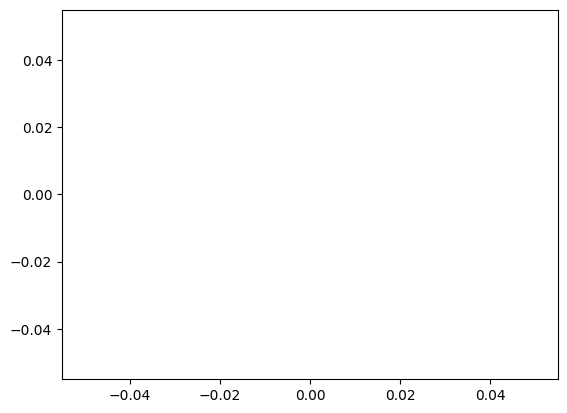

In [12]:
plt.scatter(test_times[mask].detach().cpu(), np.exp(logpdf[mask].detach().cpu()))
sns.histplot(test_times[mask].detach().cpu(), stat="density")

<AxesSubplot:ylabel='Density'>

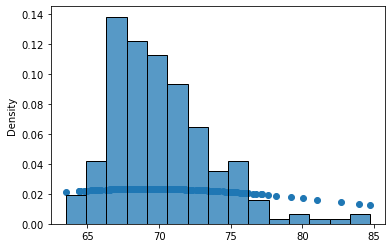

In [29]:
plt.scatter(test_per_pmt[:].detach().cpu(), np.exp(logpdf.detach().cpu()))
sns.histplot(test_per_pmt[:].detach().cpu(), stat="density")

In [34]:
labels, features = next(iter(dl))

ValueError: Shape of passed values is (2, 5126), indices imply (2, 2)

In [9]:
pdf=jammy_flows.pdf("e1", "gggg")

<KeysViewHDF5 ['dataset_1', 'dataset_10', 'dataset_11', 'dataset_12', 'dataset_2', 'dataset_3', 'dataset_4', 'dataset_5', 'dataset_6', 'dataset_7', 'dataset_8', 'dataset_9']>

In [9]:
with h5py.File("../assets/photon_table.hd5") as hdl:
    print(hdl["photon_tables/dataset_2"][:, 0])

IndexError: Index (0) out of range for empty dimension